In [1]:
from netCDF4 import Dataset
import rasterio
import os
from datetime import datetime
import numpy as np

In [2]:
# local libraries
from coupling_PCR_FM.model_functions_v2 import PCR_model, CMF_model, DFM_model
from coupling_PCR_FM.utils import config_to_dict, determineSteps
%config Application.log_level="INFO"

In [3]:
# IMPORT MODEL SETTINGS FROM INI-FILE
argv1 = r'default_rename.set'
argv2 = r'paths.env'

# parse set/ini-file with central/general settings for coupling framework
config = config_to_dict(argv1)
# parse env-file for user-specific paths and environmental variables
envs = config_to_dict(argv2)
# combine
config.update(envs)
options = config
# parse dates
start_date = datetime.strptime(options['numerical_settings']['startTime'], '%Y-%m-%d')
end_date = datetime.strptime(options['numerical_settings']['endTime'], '%Y-%m-%d')
print start_date
print end_date
timeSteps = determineSteps(start_date, end_date)
print timeSteps

2000-01-01 00:00:00
2000-12-31 00:00:00
365


In [4]:
# setup output dir
cwd = os.getcwd() # note: this get changed by pcr initialization later on
out_dir = options['PCRpaths']['outputDirectoryPCR']
out_dir = out_dir + 'PCR2CMF/'
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)
print(out_dir)
print(cwd)

/home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF/
/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim


## create PCR model BMI object

Note that we use a two step initializiation. in the first step the bmi object is initialized and the model config file is read into memory. This config file can then be changed offline before the model is initialized. This allows for change model input files and setting based on the model coupling.

In [5]:
PCR_configfile = os.path.join(cwd, options['hydrologic_model']['config_dir'], options['hydrologic_model']['config_file'])
PCR_in_dir = options['PCRpaths']['inputDirectoryPCR']
PCR_out_dir = os.path.join(out_dir, 'PCR')

PCR_bmi = PCR_model(PCR_configfile, PCR_in_dir, PCR_out_dir,
                            start_date, end_date)


The illustrate the two-step initialization, the model config file is shown

In [6]:
PCR_bmi.model_config

OrderedDict([(u'globalOptions',
              OrderedDict([('inputDir',
                            u'/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim/test_Elbe/PCR_Elbe/input30min'),
                           ('cloneMap', u'clone_elbe_30min.map'),
                           ('landmask', u'landmask_elbe_30min.map'),
                           ('outputDir',
                            u'/home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF/PCR'),
                           ('institution',
                            u'Department of Physical Geography, Utrecht University'),
                           ('title', u'PCR-GLOBWB output'),
                           ('description',
                            u'test version by Edwin H. Sutanudjaja; adapted by J. Hoch'),
                           ('startTime', '2000-01-01'),
                           ('endTime', '2000-12-31'),
                           ('maxSpinUpsInYears', u'1'),
                           ('minConvForTotlSto', u'0.5'),
  

## create CMF model BMi object

In [7]:
CMF_engine = os.path.join(cwd, options['CMF_engine']['CMF_path'])
CMF_model_dir = os.path.join(cwd, options['routing_model']['model_dir'])
CMF_config_fn = os.path.join(CMF_model_dir, options['routing_model']['model_file'])
CMF_out_dir = os.path.join(out_dir, 'CMF')
     
CMF_bmi = CMF_model(CMF_engine, CMF_config_fn, CMF_model_dir, CMF_out_dir,
                         start_date, end_date)

2018-03-05 13:52:48,963 - INFO - Loading library from path /home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim/cama-flood_bmi/src/libcama.so


## couple grids based on CMF inpmat file

In [8]:
# couple
PCR_bmi.couple_grid_to_grid(CMF_bmi)

2018-03-05 13:52:49,102 - INFO - Getting PCR model grid parameters.
2018-03-05 13:52:49,106 - INFO - Getting CMF model grid parameters.
2018-03-05 13:52:49,108 - INFO - Coupling PCR grid to CMF grid.
2018-03-05 13:52:49,109 - INFO - ./generate_inpmat 0.5 7.0 17.0 55.0 48.0 NtoS
2018-03-05 13:52:49,211 - INFO - Editing PCR ldd grid to deactivate routing in coupled cells.


## initialize models

In [9]:
# initialize model at CMF_out_dir after inpmat has been set in the grid_to_grid coupling function.
CMF_bmi.initialize()
# initialize model 
PCR_bmi.initialize()

2018-03-05 13:52:49,229 - INFO - removing tmp file diminfo_tmp.txt from model data dir
2018-03-05 13:52:49,234 - INFO - removing tmp file inpmat-tmp.txt from model data dir
2018-03-05 13:52:49,240 - INFO - removing tmp file inpmat-tmp.bin from model data dir
2018-03-05 13:52:49,243 - INFO - Ini file for CMF written to /home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF/CMF/input_flood.nam
2018-03-05 13:52:49,244 - INFO - Loading model /home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF/CMF/input_flood.nam in directory /home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF/CMF
2018-03-05 13:52:49,247 - INFO - CMF initialized
2018-03-05 13:52:49,252 - INFO - Ini file for PCR written to /home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF/PCR/setup_PCR_30min_Elbe.ini
2018-03-05 13:52:49,258 - INFO - Model run started at 2018-03-05 13:52:49.253593
2018-03-05 13:52:49,258 pcrglobwb_bmi_v203.configuration INFO Model run started at 2018-03-05 13:52:49.253593
2018-03-05 13:

## run coupled PCR - CMF model

In [10]:
# run coupled model for 20 timesteps
def update_states():
    "coupling runoff between CMFan PCR model"
    runoff = PCR_bmi.get_var('landSurfaceRunoff')
    runoff = np.where(np.isnan(runoff), 0, runoff)
    CMF_bmi.set_var("roffin", runoff)
        
tStart = datetime.now()
for i in range(timeSteps):
    PCR_bmi.update()
    update_states()
    CMF_bmi.update()   
tEnd = datetime.now()

2018-03-05 13:53:01,208 - INFO - reading forcings for time 2000-01-01
2018-03-05 13:53:01,208 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-01
2018-03-05 13:53:01,465 - INFO - updating model to time 2000-01-01
2018-03-05 13:53:01,465 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-01
2018-03-05 13:53:03,427 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-01-01, timestep 1
2018-03-05 13:53:03,427 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-01, timestep 1
2018-03-05 13:53:03,686 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-02 00:00:00, timestep 86400.0
2018-03-05 13:53:03,686 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-02 00:00:00, timestep 86400.0
2018-03-05 13:53:03,689 - INFO - reading forcings for time 2000-01-02
2018-03-05 13:53:03,689 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-02
2

2018-03-05 13:53:17,283 - INFO - reading forcings for time 2000-01-11
2018-03-05 13:53:17,283 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-11
2018-03-05 13:53:17,569 - INFO - updating model to time 2000-01-11
2018-03-05 13:53:17,569 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-11
2018-03-05 13:53:18,580 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-01-11, timestep 11
2018-03-05 13:53:18,580 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-11, timestep 11
2018-03-05 13:53:18,648 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-12 00:00:00, timestep 86400.0
2018-03-05 13:53:18,648 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-12 00:00:00, timestep 86400.0
2018-03-05 13:53:18,650 - INFO - reading forcings for time 2000-01-12
2018-03-05 13:53:18,650 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-12

2018-03-05 13:53:32,439 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-21 00:00:00, timestep 86400.0
2018-03-05 13:53:32,445 - INFO - reading forcings for time 2000-01-21
2018-03-05 13:53:32,445 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-21
2018-03-05 13:53:32,778 - INFO - updating model to time 2000-01-21
2018-03-05 13:53:32,778 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-21
2018-03-05 13:53:33,792 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-01-21, timestep 21
2018-03-05 13:53:33,792 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-21, timestep 21
2018-03-05 13:53:33,839 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-22 00:00:00, timestep 86400.0
2018-03-05 13:53:33,839 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-22 00:00:00, timestep 86400.0
2018-03-0

2018-03-05 13:53:47,467 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-31 00:00:00, timestep 86400.0
2018-03-05 13:53:47,467 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-31 00:00:00, timestep 86400.0
2018-03-05 13:53:47,470 - INFO - reading forcings for time 2000-01-31
2018-03-05 13:53:47,470 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-31
2018-03-05 13:53:47,936 - INFO - updating model to time 2000-01-31
2018-03-05 13:53:47,936 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-31
2018-03-05 13:53:48,992 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-01-31, timestep 31
2018-03-05 13:53:48,992 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-31, timestep 31
2018-03-05 13:53:49,073 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-01 00:00:00, timestep 86400.0
2018-03-05 13:53:49,073 coupling_PCR_FM.

2018-03-05 13:54:03,513 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-09, timestep 40
2018-03-05 13:54:03,600 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-10 00:00:00, timestep 86400.0
2018-03-05 13:54:03,600 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-10 00:00:00, timestep 86400.0
2018-03-05 13:54:03,605 - INFO - reading forcings for time 2000-02-10
2018-03-05 13:54:03,605 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-10
2018-03-05 13:54:04,003 - INFO - updating model to time 2000-02-10
2018-03-05 13:54:04,003 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-10
2018-03-05 13:54:05,014 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-02-10, timestep 41
2018-03-05 13:54:05,014 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-10, timestep 41
2018-03-05 13:54:05,158 - INFO -

2018-03-05 13:54:18,281 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-02-19, timestep 50
2018-03-05 13:54:18,281 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-19, timestep 50
2018-03-05 13:54:18,312 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-20 00:00:00, timestep 86400.0
2018-03-05 13:54:18,312 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-20 00:00:00, timestep 86400.0
2018-03-05 13:54:18,314 - INFO - reading forcings for time 2000-02-20
2018-03-05 13:54:18,314 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-20
2018-03-05 13:54:18,693 - INFO - updating model to time 2000-02-20
2018-03-05 13:54:18,693 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-20
2018-03-05 13:54:19,753 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-02-20, timestep 51
2018-03-05 13:54:19,753 coupling_PCR_FM.model_functions_v2 INFO

2018-03-05 13:54:32,244 - INFO - updating model to time 2000-02-29
2018-03-05 13:54:32,244 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-29
2018-03-05 13:54:33,292 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-02-29, timestep 60
2018-03-05 13:54:33,292 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-29, timestep 60
2018-03-05 13:54:33,352 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-01 00:00:00, timestep 86400.0
2018-03-05 13:54:33,352 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-01 00:00:00, timestep 86400.0
2018-03-05 13:54:33,360 - INFO - reading forcings for time 2000-03-01
2018-03-05 13:54:33,360 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-01
2018-03-05 13:54:33,684 - INFO - updating model to time 2000-03-01
2018-03-05 13:54:33,684 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-01
2018-

2018-03-05 13:54:46,746 - INFO - reading forcings for time 2000-03-10
2018-03-05 13:54:46,746 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-10
2018-03-05 13:54:47,129 - INFO - updating model to time 2000-03-10
2018-03-05 13:54:47,129 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-10
2018-03-05 13:54:48,257 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-03-10, timestep 70
2018-03-05 13:54:48,257 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-10, timestep 70
2018-03-05 13:54:48,365 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-11 00:00:00, timestep 86400.0
2018-03-05 13:54:48,365 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-11 00:00:00, timestep 86400.0
2018-03-05 13:54:48,373 - INFO - reading forcings for time 2000-03-11
2018-03-05 13:54:48,373 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-11

2018-03-05 13:55:02,040 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-20 00:00:00, timestep 86400.0
2018-03-05 13:55:02,042 - INFO - reading forcings for time 2000-03-20
2018-03-05 13:55:02,042 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-20
2018-03-05 13:55:02,347 - INFO - updating model to time 2000-03-20
2018-03-05 13:55:02,347 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-20
2018-03-05 13:55:03,372 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-03-20, timestep 80
2018-03-05 13:55:03,372 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-20, timestep 80
2018-03-05 13:55:03,445 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-21 00:00:00, timestep 86400.0
2018-03-05 13:55:03,445 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-21 00:00:00, timestep 86400.0
2018-03-0

2018-03-05 13:55:16,804 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-30 00:00:00, timestep 86400.0
2018-03-05 13:55:16,804 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-30 00:00:00, timestep 86400.0
2018-03-05 13:55:16,826 - INFO - reading forcings for time 2000-03-30
2018-03-05 13:55:16,826 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-30
2018-03-05 13:55:17,119 - INFO - updating model to time 2000-03-30
2018-03-05 13:55:17,119 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-30
2018-03-05 13:55:18,161 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-03-30, timestep 90
2018-03-05 13:55:18,161 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-30, timestep 90
2018-03-05 13:55:18,230 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-31 00:00:00, timestep 86400.0
2018-03-05 13:55:18,230 coupling_PCR_FM.

2018-03-05 13:55:32,141 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-08, timestep 99
2018-03-05 13:55:32,191 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-09 00:00:00, timestep 86400.0
2018-03-05 13:55:32,191 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-09 00:00:00, timestep 86400.0
2018-03-05 13:55:32,193 - INFO - reading forcings for time 2000-04-09
2018-03-05 13:55:32,193 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-09
2018-03-05 13:55:32,535 - INFO - updating model to time 2000-04-09
2018-03-05 13:55:32,535 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-09
2018-03-05 13:55:33,573 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-04-09, timestep 100
2018-03-05 13:55:33,573 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-09, timestep 100
2018-03-05 13:55:33,635 - INFO

2018-03-05 13:55:46,804 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-04-18, timestep 109
2018-03-05 13:55:46,804 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-18, timestep 109
2018-03-05 13:55:46,832 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-19 00:00:00, timestep 86400.0
2018-03-05 13:55:46,832 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-19 00:00:00, timestep 86400.0
2018-03-05 13:55:46,833 - INFO - reading forcings for time 2000-04-19
2018-03-05 13:55:46,833 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-19
2018-03-05 13:55:47,147 - INFO - updating model to time 2000-04-19
2018-03-05 13:55:47,147 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-19
2018-03-05 13:55:48,232 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-04-19, timestep 110
2018-03-05 13:55:48,232 coupling_PCR_FM.model_functions_v2 I

2018-03-05 13:56:00,396 - INFO - updating model to time 2000-04-28
2018-03-05 13:56:00,396 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-28
2018-03-05 13:56:01,456 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-04-28, timestep 119
2018-03-05 13:56:01,456 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-28, timestep 119
2018-03-05 13:56:01,520 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-29 00:00:00, timestep 86400.0
2018-03-05 13:56:01,520 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-29 00:00:00, timestep 86400.0
2018-03-05 13:56:01,533 - INFO - reading forcings for time 2000-04-29
2018-03-05 13:56:01,533 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-29
2018-03-05 13:56:01,796 - INFO - updating model to time 2000-04-29
2018-03-05 13:56:01,796 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-29
201

2018-03-05 13:56:14,736 - INFO - reading forcings for time 2000-05-08
2018-03-05 13:56:14,736 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-08
2018-03-05 13:56:15,038 - INFO - updating model to time 2000-05-08
2018-03-05 13:56:15,038 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-08
2018-03-05 13:56:16,052 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-05-08, timestep 129
2018-03-05 13:56:16,052 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-08, timestep 129
2018-03-05 13:56:16,120 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-09 00:00:00, timestep 86400.0
2018-03-05 13:56:16,120 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-09 00:00:00, timestep 86400.0
2018-03-05 13:56:16,122 - INFO - reading forcings for time 2000-05-09
2018-03-05 13:56:16,122 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-

2018-03-05 13:56:29,322 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-18 00:00:00, timestep 86400.0
2018-03-05 13:56:29,328 - INFO - reading forcings for time 2000-05-18
2018-03-05 13:56:29,328 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-18
2018-03-05 13:56:29,624 - INFO - updating model to time 2000-05-18
2018-03-05 13:56:29,624 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-18
2018-03-05 13:56:30,700 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-05-18, timestep 139
2018-03-05 13:56:30,700 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-18, timestep 139
2018-03-05 13:56:30,903 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-19 00:00:00, timestep 86400.0
2018-03-05 13:56:30,903 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-19 00:00:00, timestep 86400.0
2018-03

2018-03-05 13:56:44,213 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-28 00:00:00, timestep 86400.0
2018-03-05 13:56:44,213 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-28 00:00:00, timestep 86400.0
2018-03-05 13:56:44,216 - INFO - reading forcings for time 2000-05-28
2018-03-05 13:56:44,216 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-28
2018-03-05 13:56:44,630 - INFO - updating model to time 2000-05-28
2018-03-05 13:56:44,630 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-28
2018-03-05 13:56:45,720 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-05-28, timestep 149
2018-03-05 13:56:45,720 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-28, timestep 149
2018-03-05 13:56:45,778 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-29 00:00:00, timestep 86400.0
2018-03-05 13:56:45,778 coupling_PCR_F

2018-03-05 13:56:59,166 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-06, timestep 158
2018-03-05 13:56:59,437 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-07 00:00:00, timestep 86400.0
2018-03-05 13:56:59,437 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-07 00:00:00, timestep 86400.0
2018-03-05 13:56:59,442 - INFO - reading forcings for time 2000-06-07
2018-03-05 13:56:59,442 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-07
2018-03-05 13:56:59,850 - INFO - updating model to time 2000-06-07
2018-03-05 13:56:59,850 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-07
2018-03-05 13:57:00,849 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-06-07, timestep 159
2018-03-05 13:57:00,849 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-07, timestep 159
2018-03-05 13:57:00,910 - INF

2018-03-05 13:57:14,129 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-06-16, timestep 168
2018-03-05 13:57:14,129 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-16, timestep 168
2018-03-05 13:57:14,204 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-17 00:00:00, timestep 86400.0
2018-03-05 13:57:14,204 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-17 00:00:00, timestep 86400.0
2018-03-05 13:57:14,212 - INFO - reading forcings for time 2000-06-17
2018-03-05 13:57:14,212 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-17
2018-03-05 13:57:14,559 - INFO - updating model to time 2000-06-17
2018-03-05 13:57:14,559 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-17
2018-03-05 13:57:15,580 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-06-17, timestep 169
2018-03-05 13:57:15,580 coupling_PCR_FM.model_functions_v2 I

2018-03-05 13:57:27,894 - INFO - updating model to time 2000-06-26
2018-03-05 13:57:27,894 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-26
2018-03-05 13:57:28,950 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-06-26, timestep 178
2018-03-05 13:57:28,950 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-26, timestep 178
2018-03-05 13:57:28,984 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-27 00:00:00, timestep 86400.0
2018-03-05 13:57:28,984 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-27 00:00:00, timestep 86400.0
2018-03-05 13:57:28,989 - INFO - reading forcings for time 2000-06-27
2018-03-05 13:57:28,989 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-27
2018-03-05 13:57:29,356 - INFO - updating model to time 2000-06-27
2018-03-05 13:57:29,356 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-27
201

2018-03-05 13:57:42,566 - INFO - reading forcings for time 2000-07-06
2018-03-05 13:57:42,566 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-06
2018-03-05 13:57:42,962 - INFO - updating model to time 2000-07-06
2018-03-05 13:57:42,962 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-06
2018-03-05 13:57:44,058 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-07-06, timestep 188
2018-03-05 13:57:44,058 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-06, timestep 188
2018-03-05 13:57:44,092 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-07 00:00:00, timestep 86400.0
2018-03-05 13:57:44,092 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-07 00:00:00, timestep 86400.0
2018-03-05 13:57:44,094 - INFO - reading forcings for time 2000-07-07
2018-03-05 13:57:44,094 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-

2018-03-05 13:57:57,677 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-16 00:00:00, timestep 86400.0
2018-03-05 13:57:57,695 - INFO - reading forcings for time 2000-07-16
2018-03-05 13:57:57,695 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-16
2018-03-05 13:57:57,973 - INFO - updating model to time 2000-07-16
2018-03-05 13:57:57,973 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-16
2018-03-05 13:57:59,020 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-07-16, timestep 198
2018-03-05 13:57:59,020 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-16, timestep 198
2018-03-05 13:57:59,139 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-17 00:00:00, timestep 86400.0
2018-03-05 13:57:59,139 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-17 00:00:00, timestep 86400.0
2018-03

2018-03-05 13:58:12,329 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-26 00:00:00, timestep 86400.0
2018-03-05 13:58:12,329 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-26 00:00:00, timestep 86400.0
2018-03-05 13:58:12,331 - INFO - reading forcings for time 2000-07-26
2018-03-05 13:58:12,331 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-26
2018-03-05 13:58:12,814 - INFO - updating model to time 2000-07-26
2018-03-05 13:58:12,814 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-26
2018-03-05 13:58:13,834 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-07-26, timestep 208
2018-03-05 13:58:13,834 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-26, timestep 208
2018-03-05 13:58:13,890 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-27 00:00:00, timestep 86400.0
2018-03-05 13:58:13,890 coupling_PCR_F

2018-03-05 13:58:27,378 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-04, timestep 217
2018-03-05 13:58:27,631 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-05 00:00:00, timestep 86400.0
2018-03-05 13:58:27,631 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-05 00:00:00, timestep 86400.0
2018-03-05 13:58:27,634 - INFO - reading forcings for time 2000-08-05
2018-03-05 13:58:27,634 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-05
2018-03-05 13:58:27,973 - INFO - updating model to time 2000-08-05
2018-03-05 13:58:27,973 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-05
2018-03-05 13:58:29,063 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-08-05, timestep 218
2018-03-05 13:58:29,063 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-05, timestep 218
2018-03-05 13:58:29,123 - INF

2018-03-05 13:58:42,332 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-08-14, timestep 227
2018-03-05 13:58:42,332 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-14, timestep 227
2018-03-05 13:58:42,408 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-15 00:00:00, timestep 86400.0
2018-03-05 13:58:42,408 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-15 00:00:00, timestep 86400.0
2018-03-05 13:58:42,414 - INFO - reading forcings for time 2000-08-15
2018-03-05 13:58:42,414 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-15
2018-03-05 13:58:42,814 - INFO - updating model to time 2000-08-15
2018-03-05 13:58:42,814 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-15
2018-03-05 13:58:43,829 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-08-15, timestep 228
2018-03-05 13:58:43,829 coupling_PCR_FM.model_functions_v2 I

2018-03-05 13:58:56,071 - INFO - updating model to time 2000-08-24
2018-03-05 13:58:56,071 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-24
2018-03-05 13:58:57,100 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-08-24, timestep 237
2018-03-05 13:58:57,100 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-24, timestep 237
2018-03-05 13:58:57,138 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-25 00:00:00, timestep 86400.0
2018-03-05 13:58:57,138 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-25 00:00:00, timestep 86400.0
2018-03-05 13:58:57,140 - INFO - reading forcings for time 2000-08-25
2018-03-05 13:58:57,140 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-25
2018-03-05 13:58:57,482 - INFO - updating model to time 2000-08-25
2018-03-05 13:58:57,482 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-25
201

2018-03-05 13:59:10,778 - INFO - reading forcings for time 2000-09-03
2018-03-05 13:59:10,778 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-03
2018-03-05 13:59:11,098 - INFO - updating model to time 2000-09-03
2018-03-05 13:59:11,098 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-03
2018-03-05 13:59:12,158 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-09-03, timestep 247
2018-03-05 13:59:12,158 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-03, timestep 247
2018-03-05 13:59:12,217 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-04 00:00:00, timestep 86400.0
2018-03-05 13:59:12,217 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-04 00:00:00, timestep 86400.0
2018-03-05 13:59:12,219 - INFO - reading forcings for time 2000-09-04
2018-03-05 13:59:12,219 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-

2018-03-05 13:59:25,955 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-13 00:00:00, timestep 86400.0
2018-03-05 13:59:25,957 - INFO - reading forcings for time 2000-09-13
2018-03-05 13:59:25,957 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-13
2018-03-05 13:59:26,256 - INFO - updating model to time 2000-09-13
2018-03-05 13:59:26,256 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-13
2018-03-05 13:59:27,300 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-09-13, timestep 257
2018-03-05 13:59:27,300 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-13, timestep 257
2018-03-05 13:59:27,399 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-14 00:00:00, timestep 86400.0
2018-03-05 13:59:27,399 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-14 00:00:00, timestep 86400.0
2018-03

2018-03-05 13:59:40,579 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-23 00:00:00, timestep 86400.0
2018-03-05 13:59:40,579 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-23 00:00:00, timestep 86400.0
2018-03-05 13:59:40,581 - INFO - reading forcings for time 2000-09-23
2018-03-05 13:59:40,581 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-23
2018-03-05 13:59:40,950 - INFO - updating model to time 2000-09-23
2018-03-05 13:59:40,950 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-23
2018-03-05 13:59:42,007 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-09-23, timestep 267
2018-03-05 13:59:42,007 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-23, timestep 267
2018-03-05 13:59:42,057 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-24 00:00:00, timestep 86400.0
2018-03-05 13:59:42,057 coupling_PCR_F

2018-03-05 13:59:55,544 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-02, timestep 276
2018-03-05 13:59:55,740 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-03 00:00:00, timestep 86400.0
2018-03-05 13:59:55,740 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-03 00:00:00, timestep 86400.0
2018-03-05 13:59:55,743 - INFO - reading forcings for time 2000-10-03
2018-03-05 13:59:55,743 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-03
2018-03-05 13:59:56,148 - INFO - updating model to time 2000-10-03
2018-03-05 13:59:56,148 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-03
2018-03-05 13:59:57,157 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-10-03, timestep 277
2018-03-05 13:59:57,157 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-03, timestep 277
2018-03-05 13:59:57,210 - INF

2018-03-05 14:00:10,757 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-10-12, timestep 286
2018-03-05 14:00:10,757 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-12, timestep 286
2018-03-05 14:00:10,817 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-13 00:00:00, timestep 86400.0
2018-03-05 14:00:10,817 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-13 00:00:00, timestep 86400.0
2018-03-05 14:00:10,823 - INFO - reading forcings for time 2000-10-13
2018-03-05 14:00:10,823 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-13
2018-03-05 14:00:11,172 - INFO - updating model to time 2000-10-13
2018-03-05 14:00:11,172 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-13
2018-03-05 14:00:12,217 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-10-13, timestep 287
2018-03-05 14:00:12,217 coupling_PCR_FM.model_functions_v2 I

2018-03-05 14:00:24,646 - INFO - updating model to time 2000-10-22
2018-03-05 14:00:24,646 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-22
2018-03-05 14:00:25,673 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-10-22, timestep 296
2018-03-05 14:00:25,673 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-22, timestep 296
2018-03-05 14:00:25,829 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-23 00:00:00, timestep 86400.0
2018-03-05 14:00:25,829 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-23 00:00:00, timestep 86400.0
2018-03-05 14:00:25,834 - INFO - reading forcings for time 2000-10-23
2018-03-05 14:00:25,834 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-23
2018-03-05 14:00:26,227 - INFO - updating model to time 2000-10-23
2018-03-05 14:00:26,227 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-23
201

2018-03-05 14:00:39,048 - INFO - reading forcings for time 2000-11-01
2018-03-05 14:00:39,048 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-01
2018-03-05 14:00:39,374 - INFO - updating model to time 2000-11-01
2018-03-05 14:00:39,374 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-01
2018-03-05 14:00:40,642 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-11-01, timestep 306
2018-03-05 14:00:40,642 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-01, timestep 306
2018-03-05 14:00:40,696 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-02 00:00:00, timestep 86400.0
2018-03-05 14:00:40,696 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-02 00:00:00, timestep 86400.0
2018-03-05 14:00:40,703 - INFO - reading forcings for time 2000-11-02
2018-03-05 14:00:40,703 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-

2018-03-05 14:00:54,092 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-11 00:00:00, timestep 86400.0
2018-03-05 14:00:54,100 - INFO - reading forcings for time 2000-11-11
2018-03-05 14:00:54,100 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-11
2018-03-05 14:00:54,495 - INFO - updating model to time 2000-11-11
2018-03-05 14:00:54,495 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-11
2018-03-05 14:00:55,589 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-11-11, timestep 316
2018-03-05 14:00:55,589 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-11, timestep 316
2018-03-05 14:00:55,682 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-12 00:00:00, timestep 86400.0
2018-03-05 14:00:55,682 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-12 00:00:00, timestep 86400.0
2018-03

2018-03-05 14:01:09,668 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-21 00:00:00, timestep 86400.0
2018-03-05 14:01:09,668 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-21 00:00:00, timestep 86400.0
2018-03-05 14:01:09,674 - INFO - reading forcings for time 2000-11-21
2018-03-05 14:01:09,674 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-21
2018-03-05 14:01:10,109 - INFO - updating model to time 2000-11-21
2018-03-05 14:01:10,109 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-21
2018-03-05 14:01:11,071 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-11-21, timestep 326
2018-03-05 14:01:11,071 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-21, timestep 326
2018-03-05 14:01:11,128 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-22 00:00:00, timestep 86400.0
2018-03-05 14:01:11,128 coupling_PCR_F

2018-03-05 14:01:24,613 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-30, timestep 335
2018-03-05 14:01:24,690 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-01 00:00:00, timestep 86400.0
2018-03-05 14:01:24,690 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-01 00:00:00, timestep 86400.0
2018-03-05 14:01:24,696 - INFO - reading forcings for time 2000-12-01
2018-03-05 14:01:24,696 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-01
2018-03-05 14:01:25,067 - INFO - updating model to time 2000-12-01
2018-03-05 14:01:25,067 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-01
2018-03-05 14:01:26,342 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-12-01, timestep 336
2018-03-05 14:01:26,342 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-01, timestep 336
2018-03-05 14:01:26,412 - INF

2018-03-05 14:01:39,646 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-12-10, timestep 345
2018-03-05 14:01:39,646 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-10, timestep 345
2018-03-05 14:01:39,708 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-11 00:00:00, timestep 86400.0
2018-03-05 14:01:39,708 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-11 00:00:00, timestep 86400.0
2018-03-05 14:01:39,714 - INFO - reading forcings for time 2000-12-11
2018-03-05 14:01:39,714 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-11
2018-03-05 14:01:40,059 - INFO - updating model to time 2000-12-11
2018-03-05 14:01:40,059 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-11
2018-03-05 14:01:41,052 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-12-11, timestep 346
2018-03-05 14:01:41,052 coupling_PCR_FM.model_functions_v2 I

2018-03-05 14:01:53,732 - INFO - updating model to time 2000-12-20
2018-03-05 14:01:53,732 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-20
2018-03-05 14:01:54,819 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-12-20, timestep 355
2018-03-05 14:01:54,819 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-20, timestep 355
2018-03-05 14:01:54,870 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-21 00:00:00, timestep 86400.0
2018-03-05 14:01:54,870 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-21 00:00:00, timestep 86400.0
2018-03-05 14:01:54,878 - INFO - reading forcings for time 2000-12-21
2018-03-05 14:01:54,878 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-21
2018-03-05 14:01:55,288 - INFO - updating model to time 2000-12-21
2018-03-05 14:01:55,288 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-21
201

2018-03-05 14:02:08,396 - INFO - reading forcings for time 2000-12-30
2018-03-05 14:02:08,396 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-30
2018-03-05 14:02:08,702 - INFO - updating model to time 2000-12-30
2018-03-05 14:02:08,702 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-30
2018-03-05 14:02:09,783 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-12-30, timestep 365
2018-03-05 14:02:09,783 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-30, timestep 365
2018-03-05 14:02:09,853 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-31 00:00:00, timestep 86400.0
2018-03-05 14:02:09,853 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-31 00:00:00, timestep 86400.0


In [11]:
print 'start time coupling: ', tStart
print 'end time coupling: ', tEnd
print 'average time per update PCR->CMF->DFM: ', abs((tEnd - tStart)) / timeSteps

start time coupling:  2018-03-05 13:53:01.207971
end time coupling:  2018-03-05 14:02:09.856129
average time per update PCR->CMF->DFM:  0:00:01.503145


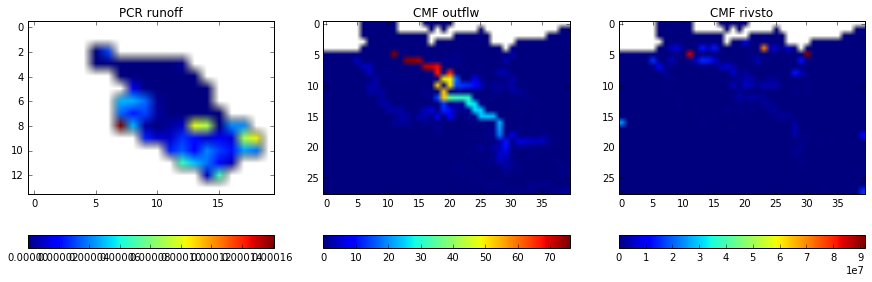

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

# PCR_bmi.update()
# routingModel.update_states()
# routingModel.update() 

runoff = PCR_bmi.get_var('landSurfaceRunoff')
outflw = CMF_bmi.get_var('outflw')
outflw = np.ma.masked_greater(outflw, 1.e19)
rivsto = CMF_bmi.get_var('rivsto_out')
rivsto = np.ma.masked_greater(rivsto, 1.e19)

fig = plt.figure(figsize=(15, 5))
a=fig.add_subplot(1,3,1)
imgplot = plt.imshow(runoff)
a.set_title('PCR runoff')
plt.colorbar(orientation ='horizontal')
a=fig.add_subplot(1,3,2)
imgplot = plt.imshow(outflw)
a.set_title('CMF outflw')
plt.colorbar(orientation='horizontal')
a=fig.add_subplot(1,3,3)
imgplot = plt.imshow(rivsto)
a.set_title('CMF rivsto')
plt.colorbar(orientation='horizontal')

In [13]:
# finalize model
PCR_bmi.finalize()

# finalize model
CMF_bmi.finalize()

2018-03-05 14:02:10,977 - INFO - cd /home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim
2018-03-05 14:02:10,977 bmi.wrapper INFO cd /home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim
